# Non-backtracking random walks in network sampling algorithms

In [1]:
import sys
import networkx as nx
import random
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from numpy import linalg as la
from networkx.algorithms.centrality import degree_centrality
from networkx.algorithms.centrality import eigenvector_centrality_numpy
from scipy import sparse as sp
import collections
import json

In [2]:
from matplotlib.ticker import (
    ScalarFormatter,
    PercentFormatter,
    LinearLocator,
    FixedLocator,
)

## Simple and biased random walk sampling

In [59]:
def srw(G, size):
    """Finds sample from network G of the desired size using a simple random walk. 
    
    Args: 
        G: networkX graph
        size: int size of the sample
    Returns: 
        S: list nodes in the sample
    """
    
    # initialise lists of sampled nodes and values 
    S = []
    n = len(G.nodes())
    y = np.zeros(size)
    
    # start at random node
    nstart = random.choice(list(G.nodes()))
    ns = 1 
    S.append(nstart)
    
    while ns < size:
        # choose a neighbour at random
        node = random.choice(list(G.neighbors(nstart)))

        # store visited nodes
        nstart = node
        S.append(node)
        ns += 1
    
    return S

In [60]:
def nb_centrality(G):
    """Calculates the nonbacktracking centrality. 
    
    Args: 
        G: networkX graph
        size: int size of the sample
        dangling: str instruction on how to handle dangling nodes
    Returns: 
        S: list nodes in the sample
    """
    
    n = len(G)
    A = nx.adjacency_matrix(G).tocoo()
    I = sp.eye(n)
    
    # degree matrix D
    D = sp.diags(list(dict(G.degree()).values()), 0)
    D_prime = I - D
    
    # 2n x 2n matrix M
    M = sp.bmat([[A, D_prime], [I, None]])
    
    # calculate the leading eigenvector
    vals, vecs = sp.linalg.eigs(M, k=1, which='LR')
    idx = np.argmax(np.abs(vals))

    # take absolute value assuming the leading eigenval is not degenerate 
    max_vec = np.array(np.abs(np.real(vecs[:,idx]))) 
    cent = dict(zip(list(G.nodes), max_vec.tolist()))
    return cent

In [61]:
def centrality_rw(G, size, centrality_type=None, dangling=None):
    """Finds sample from network G of the desired size using a random walk driven by node centrality. 
    
    Args: 
        G: networkX graph
        size: int size of the sample
        centrality_type: nb_centrality or built-in eigenvector_centrality_numpy
        dangling: str instruction on how to handle dangling nodes; None or 'remove'
    Returns: 
        S: list nodes in the sample
    """
    
    if size == 0:
        return []
    
    if dangling == 'remove':
        remove = [node for node,degree in dict(G.degree()).items() if degree == 1]
        G.remove_nodes_from(remove)
    
    # initialise lists of sampled nodes and values 
    S = np.zeros(size)
    n = len(G.nodes())
    y = np.zeros(size)
    
    # start at random node
    nstart = random.choice(list(G.nodes()))
    ns = 1 
    S[0] = nstart
    centrality = centrality_type(G)
    while ns < size:
        
        cent = np.array([centrality[x] for x in list(G.neighbors(nstart))])
        
        # normalise probability 
        prob = cent / sum(cent)
            
        # bias the choice towards the one that has highest nb centrality 
        node = np.random.choice(list(G.neighbors(nstart)), p=prob)
                                 
        S[ns] = node
        nstart = node
        ns += 1

    return list(S.astype(int)) 

In [106]:
def centrality_nbrw(G, size, centrality_type, dangling=None):
    """Finds sample from network G of the desired size using non-backtracking random walk 
        driven by node centrality. 
    
    Args: 
        G: networkX graph
        size: int desired size of the sample
        centrality_type: nb_centrality or built-in eigenvector_centrality_numpy
        dangling: str instruction on how to handle dangling nodes; 'backtrack' or 'remove'
    Returns: 
        S: list nodes in the sample
    """
    
    if size == 0:
        return []
    
    if dangling == 'remove':
        remove = [node for node,degree in dict(G.degree()).items() if degree == 1]
        G.remove_nodes_from(remove)

    # initialise lists of sampled nodes and values 
    S = np.zeros(size)
    n = len(G.nodes())
    y = np.zeros(size)
    
    # start at random node
    current = random.choice(list(G.nodes()))
    ns = 1 
    S[0] = current
    centrality = centrality_type(G)
    while ns < size:
        
        if ns == 1: 
            neighbour_centralities = np.array([centrality[x] for x in list(G.neighbors(current))])
            # normalise probability 
            prob = neighbour_centralities / sum(neighbour_centralities)
            
            # bias the choice towards the one that has highest nb centrality 
            node = np.random.choice(list(G.neighbors(current)), p=prob)
        else: 
            neighbours = list(G.neighbors(current))
            if len(neighbours) == 1:
                # make walker backtrack if it reaches dangling node
                if dangling == 'backtrack':
                    node = S[ns-2]
                else: 
                    raise Exception('The walker got stuck at an absorbing node.')    
            else: 
                # remove previous node from list of neighbours
                neighbours.remove(S[ns-2])
                
                # compute degree centrality for neighbouring nodes
                neighbour_centralities = np.array([centrality[x] for x in neighbours])
                prob = neighbour_centralities / sum(neighbour_centralities)
            
                # choose the neighbour with the highest centrality    
                node = np.random.choice(neighbours, p=prob)
                                 
        S[ns] = node
        current = node
        ns += 1
    
    return list(S.astype(int)) 

In [177]:
def nbrw(G, size, centrality_type=None, dangling=None):
    """Finds sample from network G of the desired size using non-backtracking random walk. 
    
    Args: 
        G: networkX graph
        size: int desired size of the sample
        centrality_type: nb_centrality or built-in eigenvector_centrality_numpy
        dangling: str instruction on how to handle dangling nodes; 'backtrack' or 'remove'
    Returns: 
        S: list nodes in the sample
    """

    if size == 0:
        return []
    
    if dangling == 'remove':
        remove = [node for node,degree in dict(G.degree()).items() if degree == 1]
        G.remove_nodes_from(remove)

    # initialise lists of sampled nodes and values 
    S = np.zeros(size)
    n = len(G.nodes())
    
    # start at random node
    nstart = random.choice(list(G.nodes()))
    ns = 1 
    S[0] = nstart
    while ns < size:
        
        if ns == 1: 
            node = random.choice(list(G.neighbors(nstart)))
        else: 
            neighbours = list(G.neighbors(nstart))
            if len(neighbours) == 1:
                # make walker backtrack if it reaches dangling node
                if dangling == 'backtrack':
                    node = S[ns-2]
                else: 
                    raise Exception('The walker got stuck at an absorbing node.')    
            else:
                # remove previous node from list of neighbours
                neighbours.remove(S[ns-2])
                node = random.choice(neighbours)
                                 
        S[ns] = node
        nstart = node
        ns += 1
        
    return list(S.astype(int)) 

# Metrics to evaluate sampling quality

In [22]:
 def degree_seq(G):
    """Calculates degree sequence from graph G."""
    deg = sorted([d for n, d in G.degree()], reverse=True)
    return deg

def distsim(sample, G):
    """Calculates the cumulative degree distributions (frequency of degree) for
    the sample and its parent network, and measures the distance between them 
    using the Kolmogorov-Smirnov test.
    
    Args:  
        sample: list nodes present in the sample
        G: networkX graph which was sampled
    Returns: 
        (1 - D): float the Kolmogorov-Smirnov statistic D subtracted from one
    """
    
    sample_size = len(sample)
    sample_graph = G.subgraph(sample)
    
    # get degree sequence of sample and graph
    sample_sequence = degree_seq(sample_graph)
    graph_sequence = degree_seq(G)
        
    degreeCount_graph = collections.Counter(graph_sequence)
    deg1, cnt1 = zip(*degreeCount_graph.items())
    
    # list of degrees present in the network
    graph_degrees = list(deg1)

    degreeCount_sample = collections.Counter(sample_sequence)
    deg2, cnt2 = zip(*degreeCount_sample.items())
    
    # take difference between the two degree lists
    diff = list(set(deg1) - set(deg2))
    
    size = len(graph_degrees)

    # add zeros for count of degrees missing from the sample
    j = 0
    counts_sample = np.zeros(size)
    for i in range(size):
        if graph_degrees[i] not in diff:
            counts_sample[i] = cnt2[j]
            j += 1
    
    counts_graph = np.array(cnt1)
    
    # cumulative distributions for the graph and sample
    cum_dist_sample = np.cumsum(counts_sample[::-1]) / sum(counts_sample)
    cum_dist_graph = np.cumsum(counts_graph[::-1]) / sum(counts_graph)

    # calculate the distance using Kolmogorov-Smirnov D-statistic
    D = max(np.abs(np.subtract(cum_dist_graph, cum_dist_sample)))
    
    return 1 - D

In [187]:
def discovery_quotient(sample, G, *args):
    """Caclulates the proportion of the network discovered by a sampling strategy. 
    Number of nodes discovered is defined as a union of nodes in the sample and their neighbours. 
    The discovery quotient is this value normalized by the total number of nodes in a network.
    
    Args: 
        sample: list nodes sampled by an estimator
        G: NetworkX Graph from which the sample is taken
    Returns: 
        DQ: float fraction of nodes discovered
    """
    
    if sample == 0:
        return 0
    n = len(G.nodes())
    neighbours = []
    for node in sample: 
        neighbours.extend(G.neighbors(node))
    nodes_discovered = list(set(sample) | set(neighbours))
    return len(nodes_discovered) / n

In [196]:
def hub_inclusion(sample, G, k):
    """Find the percentege of the top k highest degree nodes 
    (hubs) present in the sample.
    
    Args: 
        sample: list nodes in the sample
        G: NetworkX Graph
        k: int number of top nodes
    Returns:
        float proportion of top k hubs in sample 
    """
    
    # find top K highest degree nodes in graph
    degrees = dict(G.degree())
    sorted_dict = sorted(degrees, key=degrees.get, reverse=True)
    hubs = sorted_dict[:k]

    # find hubs in sample
    hubs_in_sample = list((set(sample) & set(hubs)))
    
    return len(hubs_in_sample) / len(hubs)

In [123]:
from multiprocessing import Pool
import time

In [193]:
class StatisticsGenerator:
    def __init__(self, G, centrality_type, dangling, sampling_algorithm, metric, hubs):
        self.G = G
        self.centrality_type = centrality_type
        self.dangling = dangling
        self.sampling_algorithm = sampling_algorithm
        self.metric = metric
        self.hubs = hubs
        
    def parallel_sampling_algorithm(self, sample_size):
        return self.sampling_algorithm(self.G, sample_size, self.centrality_type, self.dangling)
    
    def parallel_metric(self, sample):
        return self.metric(sample, self.G, self.hubs)

In [199]:
def parallel_average(n_surveys, sampling_algorithm, G, metric, centrality_type, dangling, sample_sizes, hubs=None):
    """Caclulates the average over n_surveys of the chosen metric for graph G and samples of 
    sizes given by sample_sizes. 
        
    Args: 
        n_surveys: int number of surveys to average over 
        sampling_algorithm: function 
        G: NetworkX Graph to sample
        metric: function  
        centrality_type: nb_centrality or built-in eigenvector_centrality_numpy
        dangling: str instruction on how to handle dangling nodes; 'backtrack' or 'remove'
        sample_sizes: (numpy) array with desired sample sizes
        hubs: int number of top hubs for the hub inclusion metric
        
        
    Returns: 
        averages: numpy array with average values for each sample size
    """
    
    start = time.time()
    stat_generator = StatisticsGenerator(G, centrality_type, dangling, sampling_algorithm, metric, hubs)
    sample_sizes_len = len(sample_sizes)
    averages = np.zeros(sample_sizes_len)
    for i in range(sample_sizes_len):
        with Pool(processes=n_surveys) as p:
            samples = p.map(stat_generator.parallel_sampling_algorithm, [int(sample_sizes[i])] * n_surveys)
            statistics = p.map(stat_generator.parallel_metric, samples)
            averages[i] = sum(statistics) / len(statistics)

    end = time.time()

    print(f"Took {end - start}s")
    return averages

## Example empirical networks

### Dolphins network

In [3]:
dolphins = nx.read_edgelist("/Users/sofija/rds_nonbacktracking/out.dolphins", nodetype=int,
                              comments='%')

In [13]:
dolphins.name = 'Dolphin Social Network'

Dolphins network summary:
Name: Dolphin Social Network
Type: Graph
Number of nodes: 62
Number of edges: 159
Average degree:   5.1290


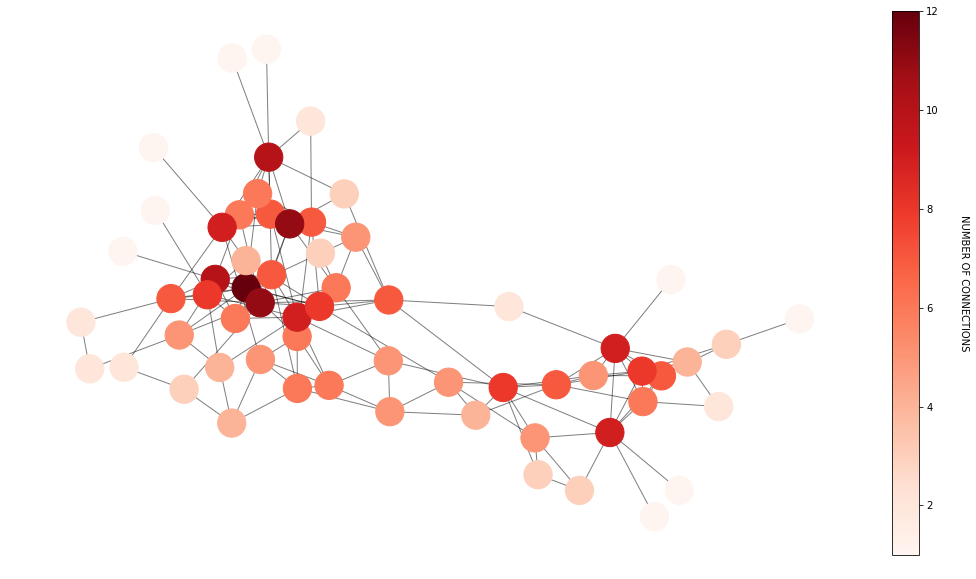

In [82]:
dol_info = nx.info(dolphins)
print(f"Dolphins network summary:\n{dol_info}")

pos = nx.layout.spring_layout(dolphins)

dolph_degrees = dict(dolphins.degree)
node_colors = list(dolph_degrees.values())

fig, ax = plt.subplots(1, 1, figsize=(18, 10));
nodes = nx.draw_networkx_nodes(dolphins, pos, node_color=node_colors, node_size=800, cmap=plt.cm.Reds, ax=ax)
edges = nx.draw_networkx_edges(dolphins, pos, node_size=800, arrowsize=10, width=1, alpha=0.5)

cbar = plt.colorbar(nodes)
cbar.set_label('NUMBER OF CONNECTIONS', rotation=270, labelpad=30)

plt.axis('off')
plt.show()
plt.close()

### Jazz network 

In [17]:
jazz_graph = nx.read_edgelist("/Users/sofija/rds_nonbacktracking/konect/out.jazz", comments='%', nodetype=int)

jazz_graph.name = 'Jazz Collaboration Network'

Jazz network summary:
Name: Jazz Collaboration Network
Type: Graph
Number of nodes: 198
Number of edges: 2742
Average degree:  27.6970


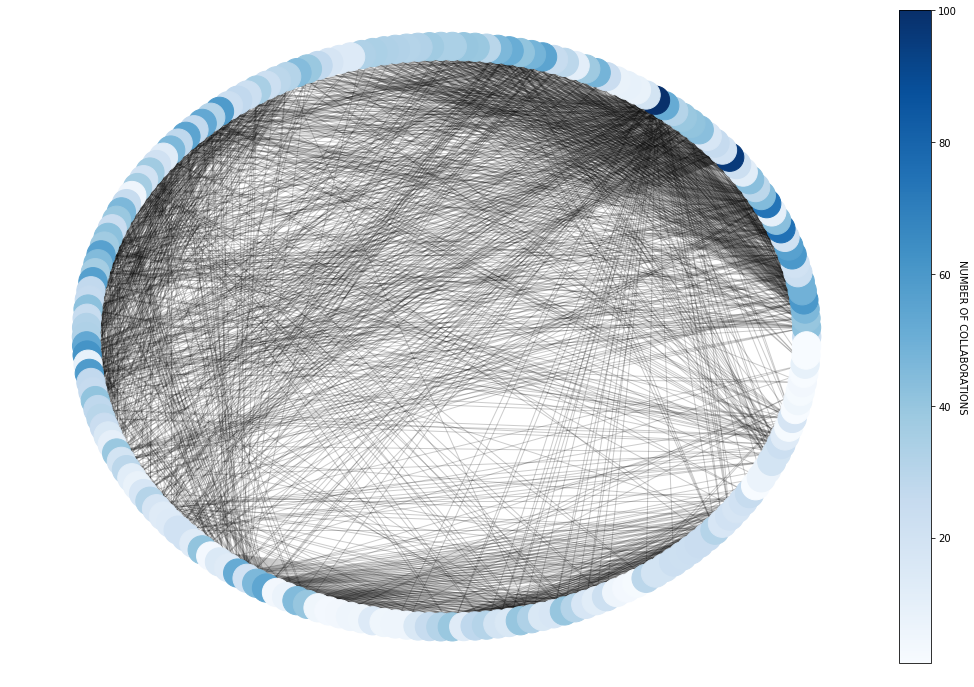

In [81]:
jazz_info = nx.info(jazz_graph)
print(f"Jazz network summary:\n{jazz_info}")

pos = nx.layout.shell_layout(jazz_graph)

jazz_degrees = dict(jazz_graph.degree)
node_colors = list(jazz_degrees.values())

fig, ax = plt.subplots(1, 1, figsize=(18, 12));
nodes = nx.draw_networkx_nodes(jazz_graph, pos, node_color=node_colors, node_size=800, cmap=plt.cm.Blues, ax=ax)
edges = nx.draw_networkx_edges(jazz_graph, pos, node_size=800, arrowsize=10, width=1, alpha=0.2)

cbar = plt.colorbar(nodes)
cbar.set_label('NUMBER OF COLLABORATIONS', rotation=270, labelpad=10)

plt.axis('off')
plt.show()
plt.close()

### Facebook network 

In [211]:
fb_graph = nx.read_edgelist("/Users/sofija/rds_nonbacktracking/facebook.txt", nodetype=int)
fb_info = nx.info(fb_graph)
print(f"Facebook network summary:\n{fb_info}")

Facebook network summary:
Name: 
Type: Graph
Number of nodes: 4039
Number of edges: 88234
Average degree:  43.6910


# Results

In [145]:
# number of surveys to average over for each sample size
n_surveys = 20

## 1. Discovery Quotient

### Jazz network

In [190]:
jazz_no_dangl = jazz_graph.copy()
centrality_nbrw(jazz_no_dangl, 10, dangling='remove', centrality_type=nb_centrality)

[46, 61, 89, 80, 103, 108, 102, 97, 54, 20]

In [191]:
jazz_sample_sizes = np.linspace(2, len(jazz_no_dangl), 30)

In [192]:
jazz_dq_srw = parallel_average(n_surveys, srw, jazz_no_dangl, discovery_quotient, None, None, jazz_sample_sizes)

Took 7.112977981567383s


In [174]:
jazz_dq_nb_centrality_nbrw = parallel_average(n_surveys, centrality_nbrw, jazz_no_dangl, discovery_quotient,
                                              nb_centrality, None, jazz_sample_sizes)

Took 16.165957927703857s


In [175]:
jazz_dq_eig_nbrw = parallel_average(n_surveys, centrality_nbrw, jazz_no_dangl, discovery_quotient,
                                    eigenvector_centrality_numpy, None, jazz_sample_sizes)

Took 13.848456144332886s


In [181]:
jazz_dq_nbrw = parallel_average(n_surveys, nbrw, jazz_no_dangl, discovery_quotient, None, None, 
                                      jazz_sample_sizes)

Took 9.344675779342651s


In [179]:
jazz_dq_centrality_rw = parallel_average(n_surveys, centrality_rw, jazz_no_dangl, discovery_quotient,
                                              nb_centrality, None, jazz_sample_sizes)

Took 15.480737209320068s


In [180]:
jazz_dq_eig_rw = parallel_average(n_surveys, centrality_rw, jazz_no_dangl, discovery_quotient,
                                    eigenvector_centrality_numpy, None, jazz_sample_sizes)

Took 15.292951107025146s


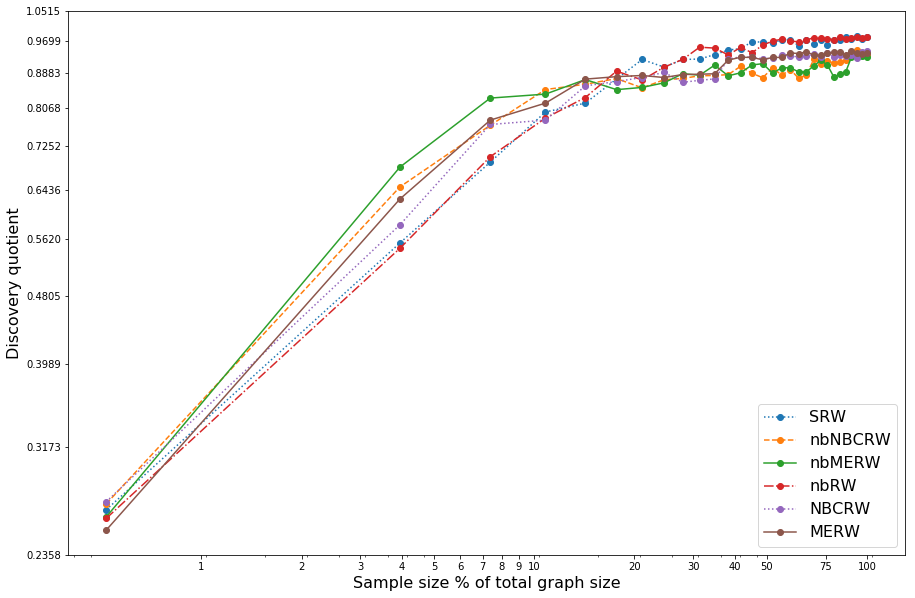

In [183]:
fig, ax = plt.subplots(figsize=(15,10))

size_jazz_dangl = len(jazz_no_dangl)
n_samples = len(jazz_sample_sizes)

# Plot discovery quotient results of different sampling strategies for the jazz graph

ax.loglog(np.linspace(1,size_jazz_dangl,n_samples), jazz_dq_srw , label='SRW', 
          linestyle=':', marker='o', markersize=6)
ax.loglog(np.linspace(1,size_jazz_dangl,n_samples), jazz_dq_nb_centrality_nbrw, label='nbNBCRW', 
          linestyle='--', marker='o', markersize=6)
ax.loglog(np.linspace(1,size_jazz_dangl,n_samples), jazz_dq_eig_nbrw, label='nbMERW',
          linestyle='-', marker='o', markersize=6)
ax.loglog(np.linspace(1,size_jazz_dangl,n_samples), jazz_dq_nbrw, label='nbRW',
          linestyle='-.', marker='o', markersize=6)
ax.loglog(np.linspace(1,size_jazz_dangl,n_samples), jazz_dq_centrality_rw, label='NBCRW',
          linestyle=':', marker='o', markersize=6)
ax.loglog(np.linspace(1,size_jazz_dangl,n_samples), jazz_dq_eig_rw, label='MERW',
          linestyle='-', marker='o', markersize=6)

# Set axis values to be linear even if plot is loglog
FIXED_CONVENIENT_PERC = [1,2,3,4,5,6,7,8,9,10,20,30,40,50,75,100]
FIXED_CONVENIENT_XS = [v*size_jazz_dangl/100 for v in FIXED_CONVENIENT_PERC]

ax.xaxis.set_major_formatter(PercentFormatter(xmax=size_jazz_dangl, decimals=0, symbol=None))
ax.xaxis.set_major_locator(FixedLocator(FIXED_CONVENIENT_XS))

ax.yaxis.set_major_formatter(ScalarFormatter(useOffset=False))
ax.yaxis.set_major_locator(LinearLocator())

# Fix odd overlapping of values seemingly due to minor locator being not null
from matplotlib.ticker import NullLocator
ax.yaxis.set_minor_locator(NullLocator())

# Set all font sizes and position legend conveniently
plt.ylabel('Discovery quotient', fontsize=16)
plt.xlabel('Sample size % of total graph size', fontsize=16)
plt.legend(fontsize=16, loc='lower right')

#plt.savefig('./output/jazz_dq_fixed.pdf')
plt.show()
plt.close()

### Facebook graph

In [201]:
facebook_no_dangl = facebook_graph.copy()
nbcrw(facebook_no_dangl, 20, nb_centrality, dangling='remove')
n_surveys = 20
fb_sample_sizes = np.linspace(5, len(facebook_no_dangl)/2, 100)

In [202]:
facebook_dq_srw = parallel_average(n_surveys, srw, facebook_no_dangl, discovery_quotient, None, None, fb_sample_sizes)

Took 519.4066209793091s


In [231]:
facebook_dq_nb_centrality_nbrw = parallel_average(n_surveys, centrality_nbrw, facebook_no_dangl, discovery_quotient,
                                              nb_centrality, None, fb_sample_sizes)

Took 1080.567012310028s


In [232]:
facebook_dq_eig_nbrw = parallel_average(n_surveys, centrality_nbrw, facebook_no_dangl, discovery_quotient,
                                    eigenvector_centrality_numpy, None, fb_sample_sizes)

Took 994.8781549930573s


In [233]:
facebook_dq_nbrw = parallel_average(n_surveys, nbrw, facebook_no_dangl, discovery_quotient, None, None, 
                                      fb_sample_sizes)

Took 318.7852008342743s


In [234]:
facebook_dq_nb_centrality_rw = parallel_average(n_surveys, centrality_rw, facebook_no_dangl, discovery_quotient,
                                              nb_centrality, None, fb_sample_sizes)

Took 990.8601269721985s


In [ ]:
fig, ax = plt.subplots(figsize=(15,10))

size_fb_dangl = len(facebook_no_dangl)

# Plot discovery quotient of different sampling strategies for the facebook graph

ax.loglog(np.linspace(1,size_fb_dangl,n_samples), facebook_dq_srw , label='SRW', 
          linestyle=':', marker='o', markersize=6)
ax.loglog(np.linspace(1,size_fb_dangl,n_samples), facebook_dq_nb_centrality_nbrw, label='nbNBCRW', 
          linestyle='--', marker='o', markersize=6)
ax.loglog(np.linspace(1,size_fb_dangl,n_samples), facebook_dq_eig_nbrw, label='nbMERW',
          linestyle='-', marker='o', markersize=6)
ax.loglog(np.linspace(1,size_fb_dangl,n_samples), facebook_dq_nbrw, label='nbRW',
          linestyle='-.', marker='o', markersize=6)
ax.loglog(np.linspace(1,size_fb_dangl,n_samples), facebook_dq_nb_centrality_rw, label='NBCRW',
          linestyle=':', marker='o', markersize=6)

# Set axis values to be linear even if plot is loglog
FIXED_CONVENIENT_PERC = [1,2,3,4,5,6,7,8,9,10,20,30,40,50]
FIXED_CONVENIENT_XS = [v*size_fb_dangl/50 for v in FIXED_CONVENIENT_PERC]

ax.xaxis.set_major_formatter(PercentFormatter(xmax=2*size_fb_dangl, decimals=0, symbol=None))
ax.xaxis.set_major_locator(FixedLocator(FIXED_CONVENIENT_XS))

ax.yaxis.set_major_formatter(ScalarFormatter(useOffset=False))
ax.yaxis.set_major_locator(LinearLocator())

# Fix odd overlapping of values seemingly due to minor locator being not null
from matplotlib.ticker import NullLocator
ax.yaxis.set_minor_locator(NullLocator())

# Set all font sizes and position legend conveniently
plt.ylabel('Discovery quotient', fontsize=16)
plt.xlabel('Sample size % of total graph size', fontsize=16)
plt.legend(fontsize=16, loc='lower right')

#plt.savefig('./output/fb_dq.pdf')
plt.show()
plt.close()

## 2. Hub inclusion

### Jazz network

In [212]:
# number of top hubs for the hub inclusion metric
hubs = 10

In [213]:
jazz_hubs_srw = parallel_average(n_surveys, srw, jazz_no_dangl, hub_inclusion, None, None, jazz_sample_sizes, hubs)

Took 7.950501203536987s


In [214]:
jazz_hubs_nb_centrality_nbrw = parallel_average(n_surveys, centrality_nbrw, jazz_no_dangl, hub_inclusion,
                                              nb_centrality, None, jazz_sample_sizes, hubs)

Took 17.294095039367676s


In [215]:
jazz_hubs_eig_nbrw = parallel_average(n_surveys, centrality_nbrw, jazz_no_dangl, hub_inclusion,
                                    eigenvector_centrality_numpy, None, jazz_sample_sizes, hubs)

Took 16.831817865371704s


In [216]:
jazz_hubs_nbrw = parallel_average(n_surveys, nbrw, jazz_no_dangl, hub_inclusion, None, None, 
                                      jazz_sample_sizes, hubs)

Took 10.288663148880005s


In [217]:
jazz_hubs_centrality_rw = parallel_average(n_surveys, centrality_rw, jazz_no_dangl, hub_inclusion,
                                              nb_centrality, None, jazz_sample_sizes, hubs)

Took 18.337621927261353s


In [218]:
jazz_hubs_eig_rw = parallel_average(n_surveys, centrality_rw, jazz_no_dangl, hub_inclusion,
                                    eigenvector_centrality_numpy, None, jazz_sample_sizes, hubs)

Took 15.632678031921387s


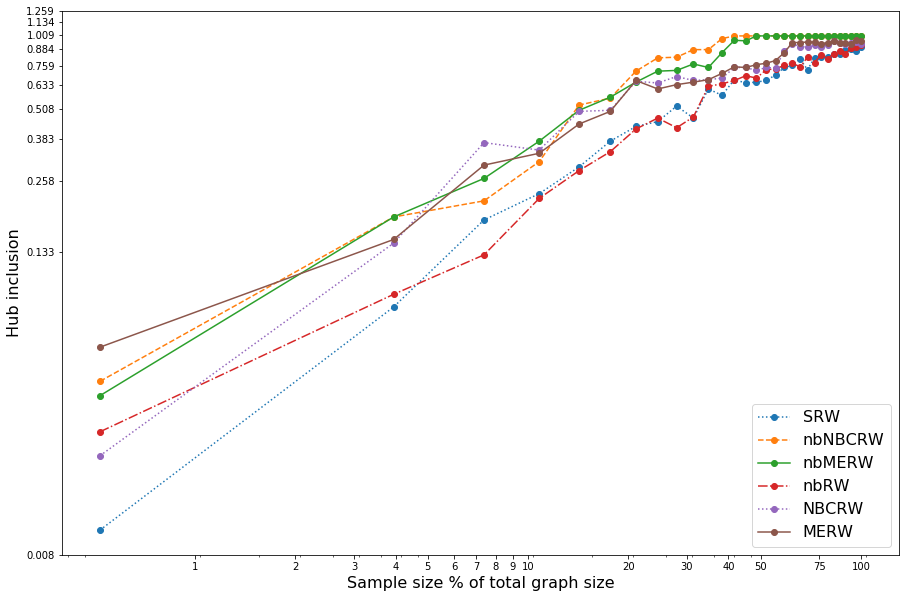

In [219]:
fig, ax = plt.subplots(figsize=(15,10))

size_jazz_dangl = len(jazz_no_dangl)
n_samples = len(jazz_sample_sizes)

# Plot discovery hub inclusion of different sampling strategies for the jazz graph

ax.loglog(np.linspace(1,size_jazz_dangl,n_samples), jazz_hubs_srw , label='SRW', 
          linestyle=':', marker='o', markersize=6)
ax.loglog(np.linspace(1,size_jazz_dangl,n_samples), jazz_hubs_nb_centrality_nbrw, label='nbNBCRW', 
          linestyle='--', marker='o', markersize=6)
ax.loglog(np.linspace(1,size_jazz_dangl,n_samples), jazz_hubs_eig_nbrw, label='nbMERW',
          linestyle='-', marker='o', markersize=6)
ax.loglog(np.linspace(1,size_jazz_dangl,n_samples), jazz_hubs_nbrw, label='nbRW',
          linestyle='-.', marker='o', markersize=6)
ax.loglog(np.linspace(1,size_jazz_dangl,n_samples), jazz_hubs_centrality_rw, label='NBCRW',
          linestyle=':', marker='o', markersize=6)
ax.loglog(np.linspace(1,size_jazz_dangl,n_samples), jazz_hubs_eig_rw, label='MERW',
          linestyle='-', marker='o', markersize=6)

# Set axis values to be linear even if plot is loglog
FIXED_CONVENIENT_PERC = [1,2,3,4,5,6,7,8,9,10,20,30,40,50,75,100]
FIXED_CONVENIENT_XS = [v*size_jazz_dangl/100 for v in FIXED_CONVENIENT_PERC]

ax.xaxis.set_major_formatter(PercentFormatter(xmax=size_jazz_dangl, decimals=0, symbol=None))
ax.xaxis.set_major_locator(FixedLocator(FIXED_CONVENIENT_XS))

ax.yaxis.set_major_formatter(ScalarFormatter(useOffset=False))
ax.yaxis.set_major_locator(LinearLocator())

# Fix odd overlapping of values seemingly due to minor locator being not null
from matplotlib.ticker import NullLocator
ax.yaxis.set_minor_locator(NullLocator())

# Set all font sizes and position legend conveniently
plt.ylabel('Hub inclusion', fontsize=16)
plt.xlabel('Sample size % of total graph size', fontsize=16)
plt.legend(fontsize=16, loc='lower right')

#plt.savefig('./output/jazz_dq_fixed.pdf')
plt.show()
plt.close()

## 3. Distribution similarity 

In [159]:
remove = [node for node,degree in dict(dolphins.degree()).items() if degree == 1]
dolphins.remove_nodes_from(remove)

dolphin_sample_sizes = np.linspace(2,len(dolphins.nodes()),20)

In [185]:
dol_dist_srw = parallel_average(n_surveys, srw, dolphins, distsim, None, None, dolphin_sample_sizes)

In [ ]:
dol_dist_nb_centrality_nbrw = parallel_average(n_surveys, centrality_nbrw, dolphins, distsim, nb_centrality, None,
                                               dolphin_sample_sizes)

In [ ]:
dol_dist_nb_centrality_rw = parallel_average(n_surveys, centrality_rw, dolphins, distsim, nb_centrality, None, 
                                             dolphin_sample_sizes)

In [ ]:
dol_dist_nbrw = parallel_average(n_surveys, nbrw, dolphins, distsim, None, None, dolphin_sample_sizes)

In [ ]:
dol_dist_eig_nbrw = parallel_average(n_surveys, centrality_nbrw, dolphins, distsim, eigenvector_centrality_numpy,
                                     None, dolphin_sample_sizes)

In [ ]:
dol_dist_eig_rw = parallel_average(n_surveys, centrality_rw, dolphins, distsim, eigenvector_centrality_numpy, None, 
                                             dolphin_sample_sizes)

In [ ]:
fig, ax = plt.subplots(figsize=(15,10))

size_dol = len(dolphins)

# Plot results for distribution similarity for the dolphins graph
ax.loglog(np.linspace(1,size_dol,n_samples), dol_dist_srw, label='SRW', 
          linestyle=':', marker='o', markersize=6)
ax.loglog(np.linspace(1,size_dol,n_samples), dol_dist_nb_centrality_nbrw, label='nbNBCRW', 
          linestyle='--', marker='o', markersize=6)
ax.loglog(np.linspace(1,size_dol,n_samples), dol_dist_eig_nbrw, label='nbMERW',
          linestyle='-', marker='o', markersize=6)
ax.loglog(np.linspace(1,size_dol,n_samples), dol_dist_nbrw, label='nbRW',
          linestyle='-.', marker='o', markersize=6)
ax.loglog(np.linspace(1,size_dol,n_samples), dol_dist_nb_centrality_rw, label='NBCRW',
          linestyle=':', marker='o', markersize=6)
ax.loglog(np.linspace(1,size_dol,n_samples), dol_dist_eig_rw, label='MERW',
          linestyle='-', marker='o', markersize=6)

# Set axis values to be linear even if plot is loglog
FIXED_CONVENIENT_PERC = [1,2,3,4,5,6,7,8,9,10,20,30,40,50,75,100]
FIXED_CONVENIENT_XS = [v*size_dol/100 for v in FIXED_CONVENIENT_PERC]

ax.xaxis.set_major_formatter(PercentFormatter(xmax=size_dol, decimals=0, symbol=None))
ax.xaxis.set_major_locator(FixedLocator(FIXED_CONVENIENT_XS))

ax.yaxis.set_major_formatter(ScalarFormatter(useOffset=False))
ax.yaxis.set_major_locator(LinearLocator())

# Fix odd overlapping of values seemingly due to minor locator being not null
from matplotlib.ticker import NullLocator
ax.yaxis.set_minor_locator(NullLocator())

# Set all font sizes and position legend conveniently
plt.ylabel('Distribution similarity', fontsize=16)
plt.xlabel('Sample size % of total graph size', fontsize=16)
plt.legend(fontsize=16, loc='lower right')

#plt.savefig('./output/dist_dolphins.pdf')
plt.show()
plt.close()